<a href="https://colab.research.google.com/github/tamirdh/Deep-learning-image-caption/blob/master/image_captioning_deep_learning_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads

In [1]:
%cd /content
!rm -rf coco
!rm -rf sample_data
!mkdir coco
%cd coco
!mkdir images
%cd images
!mkdir train2017

!wget -c http://images.cocodataset.org/zips/train2017.zip
#!wget -c http://images.cocodataset.org/zips/val2017.zip

!unzip train2017.zip
#!unzip val2017.zip

!rm train2017.zip
#!rm val2017.zip

%cd ../
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip annotations_trainval2017.zip

!rm annotations_trainval2017.zip


Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/000000547768.jpg  
 extracting: train2017/000000423162.jpg  
 extracting: train2017/000000224149.jpg  
 extracting: train2017/000000117841.jpg  
 extracting: train2017/000000251660.jpg  
 extracting: train2017/000000110997.jpg  
 extracting: train2017/000000424728.jpg  
 extracting: train2017/000000384745.jpg  
 extracting: train2017/000000475535.jpg  
 extracting: train2017/000000252604.jpg  
 extracting: train2017/000000002525.jpg  
 extracting: train2017/000000547307.jpg  
 extracting: train2017/000000546568.jpg  
 extracting: train2017/000000002024.jpg  
 extracting: train2017/000000162559.jpg  
 extracting: train2017/000000395397.jpg  
 extracting: train2017/000000255134.jpg  
 extracting: train2017/000000549188.jpg  
 extracting: train2017/000000383267.jpg  
 extracting: train2017/00

# Data Loading

## Imports and Vocabulary 

In [2]:
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from PIL import Image
import pickle

spacy_eng = spacy.load("en")

class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        # PAD- padding symbol
        # SOS- Start of Sentence
        # EOS- end of sentence
        # UNK- unknown word (unknown\ below threshold)
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold
        
    def __len__(self):
      return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for index,sentence in enumerate(sentence_list):

            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    if idx > 0 and idx % 1000==0:
                        print(f"Added {idx} words to vocab")
                    idx += 1
            if index>0 and index%1000==0:
                print(f"Iterated {index} sentences")
             

        print(f"Done, added {idx-1} words to vocabulary")
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        result = [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]
        return result

## Dataset custom class

In [3]:
import pickle
class COCODataset(Dataset):
    """
    COCODataset
    """
    def __init__(self,root_dir,annotation_file,transform=None,freq_threshold=5,
                 load_vocab=False, vocab_loc = "vocab.pkl"):
      """
      can use load_vocab to use a previously created vocabulary (time saving feature)
      freq_threshold: words with a count below this number will be marked as <UNK>
      """
      self.root_dir = root_dir
      self.coco = COCO(annotation_file)
      self.transform = transform
      self.cap_max_size = 0
      #Get image and caption colum from the dataframe
      self.imgs = []
      self.captions = []
      for idx,ann in enumerate(self.coco.anns.values()):
        self.imgs.append(self.coco.loadImgs((ann['image_id']))[0]["file_name"])
        self.captions.append(ann['caption'])
        if (idx) % 1000 == 0 and idx>0:
          print(f"Processed {idx} images and captions")
      print("Finished processing images and captions")
      print(f"Got:{len(set(self.imgs))} pictures with {len(self.captions)} captions!")
      
      #Initialize vocabulary and build vocab
      if load_vocab:
        with open(vocab_loc, "rb") as source:
          self.vocab = pickle.load(source)
        print(f"Loaded vocabulary from {vocab_loc}")
      
      else:
        print("Build vocabulary")
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions)
        print("Finished building vocabulary")
        with open(vocab_loc, "wb") as dest:
          pickle.dump(self.vocab, dest)
      
      print(f"Using {len(self.vocab)} words")
    
    def __len__(self):
      return len(self.imgs)
    
    def __getitem__(self,idx):
      caption = self.captions[idx]
      img_name = self.imgs[idx]
      img_location = os.path.join(self.root_dir,img_name)
      img = Image.open(img_location).convert("RGB")
      
      #apply the transfromation to the image
      if self.transform:
          img = self.transform(img)
      
      #numericalize the caption text
      caption_vec = [self.vocab.stoi["<SOS>"]]
      caption_vec.extend(self.vocab.numericalize(caption))
      caption_vec.append(self.vocab.stoi["<EOS>"])
      
      return img, torch.tensor(caption_vec,dtype=torch.long)

## Dataloader creation

In [4]:
# define a transformation to add some noise and variance to our images
transformation = transforms.Compose([transforms.Resize((512,512), Image.NEAREST),
                                     transforms.ToTensor(),
                                     transforms.RandomInvert(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                      ])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [5]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False, vec_len=-1):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
        self.vec_len = vec_len + 2 # adding the <SOS> and <EOS>
        assert self.vec_len > 0, "Vector length must be positive integer"
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        targets_list = list()
        for item in batch:
            # item = (img:Image, caption:tensor)
            addition = self.vec_len-len(item[1])
            padded_target = torch.cat((item[1], torch.empty(addition,dtype=torch.long).fill_(pad_idx)),dim=0)
            targets_list.append(padded_target)
            #print(f"GOT:{item[1]}, {item[1].type()}\nAdding:{addition}\nPADDED:{padded_target}\n{padded_target.type()}")
        targets = torch.stack(targets_list,0)
        #print(f"Targets shape:{targets.shape}")
        return imgs,targets

In [ ]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 1
NUM_WORKER = 1

dataset =  COCODataset(
    root_dir = "/content/coco/images/train2017",
    annotation_file= "/content/coco/annotations/captions_train2017.json",
    transform=transformation,
    freq_threshold=5,
    load_vocab=False
)

loading annotations into memory...
Done (t=1.18s)
creating index...
index created!
Processed 1000 images and captions
Processed 2000 images and captions
Processed 3000 images and captions
Processed 4000 images and captions
Processed 5000 images and captions
Processed 6000 images and captions
Processed 7000 images and captions
Processed 8000 images and captions
Processed 9000 images and captions
Processed 10000 images and captions
Processed 11000 images and captions
Processed 12000 images and captions
Processed 13000 images and captions
Processed 14000 images and captions
Processed 15000 images and captions
Processed 16000 images and captions
Processed 17000 images and captions
Processed 18000 images and captions
Processed 19000 images and captions
Processed 20000 images and captions
Processed 21000 images and captions
Processed 22000 images and captions
Processed 23000 images and captions
Processed 24000 images and captions
Processed 25000 images and captions
Processed 26000 images and

In [ ]:
from google.colab import files
files.download('vocab.pkl') 

In [ ]:

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=False,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True, vec_len=75)
)

# Models

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

class EncoderCNN(nn.Module):
  def __init__(self, embed_size, train_CNN=False):
      super(EncoderCNN, self).__init__()
      self.train_CNN = train_CNN
      self.inception = models.inception_v3(pretrained=True, aux_logits=False)
      self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(0.5)

  def forward(self, images):
      
      features = self.inception(images)
      output = self.dropout(self.relu(features))
      return output


class DecoderRNN(nn.Module):
  """
  Input is a CNN network, output will be a caption.
  TODO: Check how to implement a transformer for better results
  """
  def __init__(self, embed_size, hidden_size, vocab_size):
      super(DecoderRNN, self).__init__()
      self.hidden_size = hidden_size
      self.vocab_size = vocab_size
      self.embed = nn.Embedding(vocab_size, embed_size)
      self.lstm_cell = nn.LSTMCell(embed_size, hidden_size)
      self.fc_out = nn.Linear(hidden_size, vocab_size)
      self.dropout = nn.Dropout(0.5)

  def forward(self, features, captions, show=False):
        # batch size
        batch_size = features.size(0)
        
        
        # init the hidden and cell states to zeros
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
        # define the output tensor placeholder
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(device)

        # embed the captions
        captions_embed = self.embed(captions)
        # tensor of shape (B, LEN, EMBED SIZE)
        # LEN- vectors length (longest caption+2)
        
        # pass the caption word by word
        for t in range(captions.size(1)):

            # for the first time step the input is the feature vector
            # if t == 0:
            #     hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
                
            # # for the 2nd+ time step, using teacher forcer
            # else:
            hidden_state, cell_state = self.lstm_cell(captions_embed[:, t, :], (hidden_state, cell_state))
            # output of the attention mechanism
            out = self.fc_out(self.dropout(hidden_state))
            # build the output tensor
            outputs[:, t, :] = out
        if show:
            #print(f"Captions:{captions}")
            #print(f"outputs shape:{outputs.shape}")
            pass
        return outputs

  

class CNNtoRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, train_CNN=False):
      super(CNNtoRNN, self).__init__()
      self.encoderCNN = EncoderCNN(embed_size, train_CNN).to(device)
      self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)
      #self.decoderRNN = DecoderRNNConcat(embed_size, hidden_size, vocab_size).to(device)

  def forward(self, images, captions, show=False):
      features = self.encoderCNN(images)
      outputs = self.decoderRNN(features, captions, show)
      return outputs
  def caption_images(self, image, vocab, max_len=50):
      # Inference part
      # Given the image features generate the captions
      # input shape: (3,x,y) where, x,y: image size
      # ouput: captions list
    batch_size = image.size(0)
    assert batch_size == 1, "Caption 1 image at a time"
    image_pred = self.encoderCNN(image)

    # init the hidden and cell states to zeros
    hidden_state = torch.zeros((1, self.decoderRNN.hidden_size)).to(device)
    cell_state = torch.zeros((1, self.decoderRNN.hidden_size)).to(device)
    
    #starting input is 
    captions = list()
    outputs = torch.empty((batch_size, max_len, self.decoderRNN.vocab_size)).to(device)
    hidden_state, cell_state = self.decoderRNN.lstm_cell(image_pred, (hidden_state, cell_state))
    out = self.decoderRNN.fc_out(self.decoderRNN.dropout(hidden_state))
    word_embed = self.decoderRNN.embed(torch.tensor(vocab.stoi["<SOS>"]).to(device)).unsqueeze(0)
    for t in range(max_len):
        # for the first time step the input is the feature vector
        # if t == 0:
        #     hidden_state, cell_state = self.decoderRNN.lstm_cell(image_pred, (hidden_state, cell_state))
        # for the 2nd+ time step, use previously generated caption
        # else:
        hidden_state, cell_state = self.decoderRNN.lstm_cell(word_embed, (hidden_state, cell_state))
        
        # output of the attention mechanism
        out = self.decoderRNN.fc_out(hidden_state)
        outputs[:, t, :] = out
        print(f"out shape:{out.shape}")
        captions.append(torch.argmax(out,dim=1))
        print(f"\n predicted outputs:{captions}")
        word_embed = self.decoderRNN.embed(torch.argmax(out[0])).unsqueeze(0)
        last_word_idx = captions[-1].item()
        if vocab.itos[last_word_idx] == vocab.stoi["<EOS>"]:
            print("BREAKING!!!!!!")
            break
            
            
            # build the output tensor
        #print(captions)
        #covert the vocab idx to words and return sentence
    print(f"outputs shape:{outputs.shape}")
    print(f"Outputs argmax dim2:{torch.argmax(outputs,dim=2)}")
    return [vocab.itos[idx.item()] for idx in captions if idx.item() != vocab.stoi["<PAD>"]]
  

In [ ]:
class DecoderRNNConcat(nn.Module):
    """
    Input is a CNN network, output will be a caption.
    TODO: Check how to implement a transformer for better results
    """
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(DecoderRNNConcat, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.num_layers = 1
        self.lstm_cell = nn.LSTM(input_size=embed_size, hidden_size=hidden_size,num_layers=1, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
        
    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h0,c0


    def forward(self, features, captions):
            batch_size = features.size(0)
            captions = captions[:,:-1]
            hidden,cells = self.init_hidden(batch_size)
            embeds = self.embed(captions)
            inputs = torch.cat([features.unsqueeze(dim=1), embeds], dim=1)
            lstm_out, (hidden,cells) = self.lstm_cell(inputs, (hidden,cells))
            outputs = self.fc_out(self.dropout(lstm_out))
            return outputs
    
    def get_caption(self, features, max_len=20, end_sym=4):
        final_out = list()
        batch_size = features.size(0)
        hidden,cells = self.init_hidden(batch_size)
        while True:
            lstm_out, (hidden,cells) = self.lstm_cell(features, (hidden,cells))
            outputs = self.fc_out(self.dropout(lstm_out))
            outputs = outputs.squeeze(1)
            _, max_id = torch.max(outputs, dim=1)
            final_out.append(max_id.cpu().numpy()[0].item())
            if max_id == end_sym or len(final_out)>max_len:
                break
            features = self.embed(max_id).unsqueeze(1)
        return final_output


# Training

## training function

In [ ]:
import torch.optim as optim
from tqdm import tqdm


def train(max_epochs, model):
  # Hyperparameters
  learning_rate = 3e-4
  device = "cuda" if torch.cuda.is_available() else "cpu"

  
  # init model
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
     

  # start epochs
  for epoch in range(max_epochs):
    for idx, (img, captions) in tqdm(
            enumerate(data_loader), total=len(data_loader), leave=False
        ):
      img = img.to(device)
      captions = captions.to(device).long()
      output = model(img, captions).to(device)
      loss = criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))
      optimizer.zero_grad()
      loss.backward(loss)
      optimizer.step()

      if idx == 2:
        dataiter = iter(data_loader)
        img_show,cap = next(dataiter)
        print(f"Loss {loss.item():.5f}\n")
        demo_cap = model.caption_images(img_show[0:1].to(device), vocab=dataset.vocab, max_len=30)
        demo_cap = ' '.join(demo_cap)
        print("Predicted")
        show_image(img_show[0],title=demo_cap)
        print("Original")
        cap = cap[0]
        print(cap.long())
        demo_cap = ' '.join([dataset.vocab.itos[idx2.item()] for idx2 in cap if idx2.item() != dataset.vocab.stoi["<PAD>"]])
        show_image(img_show[0],title=demo_cap, transform=False)
        #input("Contiue?")
        break
      if idx > 20:
        break
    
        

        

  return model

## image function

In [ ]:
import matplotlib.pyplot as plt
def show_image(img, title=None, transform=True):
    """Imshow for Tensor."""
    
    #unnormalize 
    if transform:
      img[0] = img[0] * 0.229
      img[1] = img[1] * 0.224 
      img[2] = img[2] * 0.225 
      img[0] += 0.485 
      img[1] += 0.456 
      img[2] += 0.406
      
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Overfit sanity check

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
def overfit(model, T=250):
    learning_rate = 3e-4
    device = "cuda" if torch.cuda.is_available() else "cpu"

    
    # init model
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    
    dataiter = iter(data_loader)
    img,caption = next(dataiter)
    for i in tqdm(range(T)):
        # train on the same image and caption to achieve overfitting
        img = img.to(device)
        caption = caption.to(device).long()
        output = model(img, caption, show=False).to(device)
        loss = criterion(output.reshape(-1, output.shape[2]), caption.reshape(-1))
        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
    output = model(img, caption, show=True).to(device)
    show_img = img.to("cpu")
    print(f"\nLoss {loss.item():.5f}\n")
    print(f"\nForward\n")
    out_cap = torch.argmax(output[0],dim=1)
    print(f"Forwad num vals:{out_cap}")
    demo_cap = ' '.join([dataset.vocab.itos[idx2.item()] for idx2 in out_cap if idx2.item() != dataset.vocab.stoi["<PAD>"]])
    show_image(show_img[0],title=demo_cap)
    print("Predicted")
    with torch.no_grad():
        model.eval()
        demo_cap = model.caption_images(show_img[0:1].to(device), vocab=dataset.vocab, max_len=15)
        demo_cap = ' '.join(demo_cap)
        model.train()
        
        show_image(show_img[0],title=demo_cap, transform=False)
    print("Original")
    cap = caption[0]
    #print(cap.long())
    demo_cap = ' '.join([dataset.vocab.itos[idx2.item()] for idx2 in cap if idx2.item() != dataset.vocab.stoi["<PAD>"]])
    show_image(show_img[0],title=demo_cap, transform=False)

        


## Process

In [ ]:
embed_size = 1024
hidden_size = 512
vocab_size = len(dataset.vocab)
model = CNNtoRNN(embed_size, hidden_size, vocab_size, train_CNN=False)
trained_model = train(3)

# Misc

100%|██████████| 100/100 [00:20<00:00,  4.85it/s]



Loss 0.27914


Forward



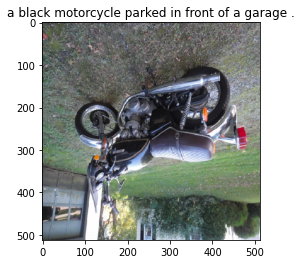

Predicted
out shape:torch.Size([1, 7228])

 predicted outputs:[tensor([0], device='cuda:0')]
out shape:torch.Size([1, 7228])

 predicted outputs:[tensor([0], device='cuda:0'), tensor([0], device='cuda:0')]
out shape:torch.Size([1, 7228])

 predicted outputs:[tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0')]
out shape:torch.Size([1, 7228])

 predicted outputs:[tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0')]
out shape:torch.Size([1, 7228])

 predicted outputs:[tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0')]
out shape:torch.Size([1, 7228])

 predicted outputs:[tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0'), tensor([0], device='cuda:0')]
out shape:torch.Size([1, 7228])

 predicte

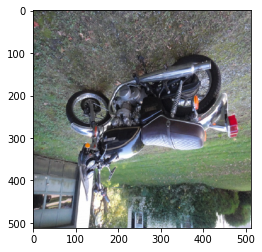

Original


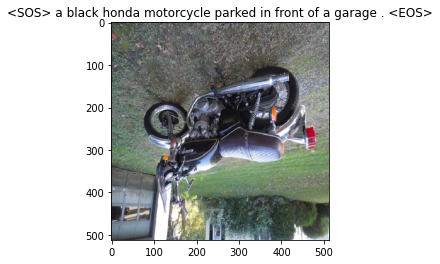

In [58]:
embed_size = 512
hidden_size = 512
vocab_size = len(dataset.vocab)
model = CNNtoRNN(embed_size, hidden_size, vocab_size, train_CNN=False)
overfit(model,100)

In [24]:
for imgs,caps in data_loader:
    print(f"\ncap shape:{caps.shape}")
    print(f"\nFirst caption:{caps[0]}")
    print(f"\nFirst embed:{caps[0][0]}")
    break


cap shape:torch.Size([1, 77])

First caption:tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11,  4, 12, 13,  2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0])

First embed:1
